# Predicting Spotify Collaborations Using Graph Representation Learning

William Chen 

QSS 82, Winter 2023

In [2]:
import pandas as pd
import numpy as np 
import networkx as nx
import matplotlib.pyplot as plt
import tqdm
import seaborn as sns

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score, confusion_matrix, f1_score, precision_score, recall_score
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

import torch
from torch import Tensor
import torch.nn as nn
from torch.nn import Linear
import torch.nn.functional as F

import torch_geometric
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader, LinkNeighborLoader
import torch_geometric.transforms as T
from torch_geometric.nn import SAGEConv, GCNConv, Node2Vec
from torch_geometric.utils import to_networkx, negative_sampling, train_test_split_edges

The data is available here: https://www.kaggle.com/datasets/jfreyberg/spotify-artist-feature-collaboration-network

In [3]:
node_df = pd.read_csv(r"C:\Users\wchen\OneDrive - Dartmouth College\Dartmouth\QSS82\spotify\nodes.csv")
edges_df = pd.read_csv(r"C:\Users\wchen\OneDrive - Dartmouth College\Dartmouth\QSS82\spotify\edges.csv")

## Process Node Attributes

In [4]:
node_df["genres"] = node_df["genres"].apply(lambda x: x[1:-1].strip())
#node_df["genres"] = node_df["genres"].apply(lambda x: x.split(','))
node_df["n_genres"] = node_df["genres"].apply(lambda x: 0 if len(x)==0 else len(x.split(',')))
node_df["spotify_id"] = node_df["spotify_id"].astype(str)
#node_df.reset_index(inplace=True)

In [5]:
# Remove artists with no followers 
node_df.drop(node_df.loc[node_df['followers']==0].index, inplace=True)

In [6]:
# Normalize popularity and follower features
node_df["popularity_norm"] = MinMaxScaler().fit_transform(node_df[["popularity"]])
node_df["log_followers"] = np.log(node_df["followers"])

In [7]:
node_df["n_genres"].describe()

count    148328.000000
mean          0.745287
std           1.356849
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max          16.000000
Name: n_genres, dtype: float64

In [8]:
# Data on each artist 
node_df

,spotify_id,name,followers,popularity,genres,chart_hits,n_genres,popularity_norm,log_followers
0,48WvrUGoijadXXCsGocwM4,Byklubben,1738.0,24,"'nordic house', 'russelater'",['no (3)'],2,0.24,7.460490
1,4lDiJcOJ2GLCK6p9q5BgfK,Kontra K,1999676.0,72,"'christlicher rap', 'german hip hop'","['at (44)', 'de (111)', 'lu (22)', 'ch (31)', ...",2,0.72,14.508496
2,652XIvIBNGg3C0KIGEJWit,Maxim,34596.0,36,,['de (1)'],0,0.36,10.451493
3,3dXC1YPbnQPsfHPVkm1ipj,Christopher Martin,249233.0,52,"'dancehall', 'lovers rock', 'modern reggae', '...","['at (1)', 'de (1)']",4,0.52,12.426143
4,74terC9ol9zMo8rfzhSOiG,Jakob Hellman,21193.0,39,"'classic swedish pop', 'norrbotten indie', 'sw...",['se (6)'],3,0.39,9.961426
...,...,...,...,...,...,...,...,...,...
156417,2ces6d2YsQP1RpGMYpdFy8,David Urwitz,5470.0,29,'classic swedish pop',NaN,1,0.29,8.607034
156418,6AeznZajNbXUulT7W4tK5l,Darmiko,2022.0,23,,NaN,0,0.23,7.611842
156419,3GEijIjrgb4lPe9WtURBzz,Katriell,268.0,0,,NaN,0,0.00,5.590987
156420,0ldQL0icSoMz9OOZcWG8Zt,Yung Fresh,181.0,19,,NaN,0,0.19,5.198497


In [9]:
node_df.shape

(148328, 9)

In [10]:
node_df["followers"].describe()

count    1.483240e+05
mean     9.092892e+04
std      9.651885e+05
min      1.000000e+00
25%      3.800000e+01
50%      4.760000e+02
75%      7.384000e+03
max      1.021569e+08
Name: followers, dtype: float64

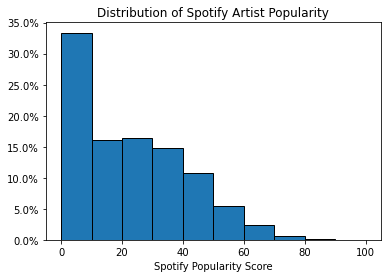

In [11]:
# Distribution of artist popularity
#node_df["popularity"].hist()
from matplotlib.ticker import PercentFormatter


plt.hist(node_df["popularity"], weights=np.ones(len(node_df)) / len(node_df), edgecolor='black')
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.xlabel("Spotify Popularity Score")
plt.title("Distribution of Spotify Artist Popularity")
plt.show()

In [12]:
node_df.loc[node_df["n_genres"]>0]

,spotify_id,name,followers,popularity,genres,chart_hits,n_genres,popularity_norm,log_followers
0,48WvrUGoijadXXCsGocwM4,Byklubben,1738.0,24,"'nordic house', 'russelater'",['no (3)'],2,0.24,7.460490
1,4lDiJcOJ2GLCK6p9q5BgfK,Kontra K,1999676.0,72,"'christlicher rap', 'german hip hop'","['at (44)', 'de (111)', 'lu (22)', 'ch (31)', ...",2,0.72,14.508496
3,3dXC1YPbnQPsfHPVkm1ipj,Christopher Martin,249233.0,52,"'dancehall', 'lovers rock', 'modern reggae', '...","['at (1)', 'de (1)']",4,0.52,12.426143
4,74terC9ol9zMo8rfzhSOiG,Jakob Hellman,21193.0,39,"'classic swedish pop', 'norrbotten indie', 'sw...",['se (6)'],3,0.39,9.961426
6,71BhXa24Zf5zcikUb00l2N,Juice,11312.0,37,"'swedish drill', 'swedish hip hop', 'swedish t...",['se (4)'],4,0.37,9.333619
...,...,...,...,...,...,...,...,...,...
156392,6HRnGwZ87Xob0I0cHSvr0s,Sevda Alekperzadeh,5634.0,8,'azeri pop',NaN,1,0.08,8.636575
156396,0By75sLZQ06mWyzNiSdLUB,Menor,26346.0,39,'funk carioca',NaN,1,0.39,10.179072
156402,7vlW9kOjO3ioYJ0k0P6xCG,Grupo Los Generales,2226.0,33,'corrido',NaN,1,0.33,7.707962
156413,6mrB3jdXxZq1dl8m8eOVFh,Getamilli,337.0,16,'ritmo kombina',NaN,1,0.16,5.820083


In [13]:
duplicates = node_df.loc[node_df.duplicated(subset=["spotify_id"])==True].sort_values(by='popularity', ascending=False)
duplicates

,spotify_id,name,followers,popularity,genres,chart_hits,n_genres,popularity_norm,log_followers
8992,1gBUSTR3TyDdTVFIaQnc02,NCT DREAM,5398388.0,72,"'k-pop', 'k-pop boy group'","['hk (3)', 'id (24)', 'jp (2)', 'my (12)', 'ph...",2,0.72,15.501611
17509,4IKVDbCSBTxBeAsMKjAuTs,Armaan Malik,15289921.0,72,"'desi pop', 'filmi', 'modern bollywood'",['in (14)'],3,0.72,16.542704
11148,44mEtidu0VdRkIqO4IbkNa,Marca MP,1417712.0,72,"'corrido', 'corridos tumbados', 'musica mexica...","['sv (1)', 'gt (2)', 'hn (1)', 'mx (4)', 'ni (...",5,0.72,14.164555
18449,3FoFW2AoUGRHBacC6i4x4p,Russ Millions,259.0,71,"'melodic drill', 'uk drill'","['gb (5)', 'au (2)', 'at (1)', 'be (2)', 'bg (...",2,0.71,5.556828
32421,5QNm7E7RU2m64l6Gliu8Oy,HARDY,199970.0,71,"'contemporary country', 'country', 'country road'",NaN,3,0.71,12.205923
...,...,...,...,...,...,...,...,...,...
134987,0fM4WhKpjJZc3a0eX947Tc,Sirius,1501.0,25,,NaN,0,0.25,7.313887
117671,6o2aThSX75afHwksESovZH,SLEEQ,14376.0,21,'malaysian hip hop',NaN,1,0.21,9.573315
69158,0xHANYVyAfbp6GmjPKcOad,Harris Baba,17492.0,21,,NaN,0,0.21,9.769499
5321,6Dv2ZL1IvCZlbSzjjj7l3w,Lidl Suomi,1997.0,17,,['fi (1)'],0,0.17,7.599401


In [14]:
# Get duplicate rows
duplicate_df = node_df[node_df['name'].isin(duplicates["name"].values)]
duplicate_df

,spotify_id,name,followers,popularity,genres,chart_hits,n_genres,popularity_norm,log_followers
349,0fM4WhKpjJZc3a0eX947Tc,Sirius,1.0,25,,NaN,0,0.25,0.000000
359,6SGCqG5HEr5gFZR9ct8wID,Matías Valdez,44663.0,58,'cumbia pop',['uy (11)'],1,0.58,10.706901
443,1B0fCkXH620aujSMm3wIKS,Sura İskenderli,362407.0,54,"'turkish pop', 'turkish trap pop'","['cy (1)', 'tr (4)']",2,0.54,12.800523
769,6RDpAm5XMUZqVZlBJ1UYQw,Starian,2.0,45,,NaN,0,0.45,0.693147
772,5VZr6vX1UPRRf9tneUEi2B,siilawy,250402.0,50,'middle east hip hop',"['eg (1)', 'ma (1)', 'sa (1)']",1,0.50,12.430823
...,...,...,...,...,...,...,...,...,...
134987,0fM4WhKpjJZc3a0eX947Tc,Sirius,1501.0,25,,NaN,0,0.25,7.313887
153014,4R3mugkUqCALXgkwSptTbg,Đạt G,195773.0,39,'vietnamese hip hop',NaN,1,0.39,12.184711
153099,0fAxJ75WJT3STJb3xWtpbc,MOLY,102882.0,43,"'dominican pop', 'modern salsa', 'pop peruano'...",NaN,5,0.43,11.541338
154938,50u2mXgysmTttY0BizYWAo,Movimiento Original,17.0,62,"'chilean rock', 'rap chileno', 'reggae en espa...",['cl (4)'],3,0.62,2.833213


In [15]:
ddf = duplicate_df.sort_values(by=['name','followers'], ascending=False).drop_duplicates('name')
ddf

,spotify_id,name,followers,popularity,genres,chart_hits,n_genres,popularity_norm,log_followers
3695,7hJBfmab67blVoqZBIAx13,鄧福如 AFÜ,41471.0,45,"'mandopop', 'taiwan pop', 'taiwan singer-songw...",['tw (4)'],3,0.45,10.632750
13960,5o5xHep3Xy0SHWx4dXMVS4,Руслан Утюг,10703.0,34,'russian indie rock',"['ru (1)', 'ua (1)']",1,0.34,9.278279
153014,4R3mugkUqCALXgkwSptTbg,Đạt G,195773.0,39,'vietnamese hip hop',NaN,1,0.39,12.184711
772,5VZr6vX1UPRRf9tneUEi2B,siilawy,250402.0,50,'middle east hip hop',"['eg (1)', 'ma (1)', 'sa (1)']",1,0.50,12.430823
11367,2wukjJRRIwHwy6TW0UMUiD,joel music,3054.0,36,,['cl (1)'],0,0.36,8.024207
...,...,...,...,...,...,...,...,...,...
5031,5RqcTk3xp9dW1BLsdQ0NE9,Aerozen,33617.0,49,'romanian trap',['ro (10)'],1,0.49,10.422787
108921,3HYI2IcaBzTQo2ZeykcvUS,Adrian Fu,1071.0,17,'cantopop',NaN,1,0.17,6.976348
11147,2DWVv9ET0trhdmdFYROQaJ,A/DA 阿達,1989.0,29,"'chinese hip hop', 'chinese r&b', 'taiwan pop'",['tw (2)'],3,0.29,7.595387
7185,6noxsCszBEEK04kCehugOp,A-Mei Chang,680051.0,58,"'c-pop', 'mandopop', 'taiwan pop'","['my (2)', 'sg (1)', 'tw (40)']",3,0.58,13.429923


In [16]:
# Drop duplicates, then add them back in 
node_df = node_df[~node_df['spotify_id'].isin(duplicates["spotify_id"].values)]
node_df = pd.concat([node_df, ddf])
node_df

,spotify_id,name,followers,popularity,genres,chart_hits,n_genres,popularity_norm,log_followers
0,48WvrUGoijadXXCsGocwM4,Byklubben,1738.0,24,"'nordic house', 'russelater'",['no (3)'],2,0.24,7.460490
1,4lDiJcOJ2GLCK6p9q5BgfK,Kontra K,1999676.0,72,"'christlicher rap', 'german hip hop'","['at (44)', 'de (111)', 'lu (22)', 'ch (31)', ...",2,0.72,14.508496
2,652XIvIBNGg3C0KIGEJWit,Maxim,34596.0,36,,['de (1)'],0,0.36,10.451493
3,3dXC1YPbnQPsfHPVkm1ipj,Christopher Martin,249233.0,52,"'dancehall', 'lovers rock', 'modern reggae', '...","['at (1)', 'de (1)']",4,0.52,12.426143
4,74terC9ol9zMo8rfzhSOiG,Jakob Hellman,21193.0,39,"'classic swedish pop', 'norrbotten indie', 'sw...",['se (6)'],3,0.39,9.961426
...,...,...,...,...,...,...,...,...,...
5031,5RqcTk3xp9dW1BLsdQ0NE9,Aerozen,33617.0,49,'romanian trap',['ro (10)'],1,0.49,10.422787
108921,3HYI2IcaBzTQo2ZeykcvUS,Adrian Fu,1071.0,17,'cantopop',NaN,1,0.17,6.976348
11147,2DWVv9ET0trhdmdFYROQaJ,A/DA 阿達,1989.0,29,"'chinese hip hop', 'chinese r&b', 'taiwan pop'",['tw (2)'],3,0.29,7.595387
7185,6noxsCszBEEK04kCehugOp,A-Mei Chang,680051.0,58,"'c-pop', 'mandopop', 'taiwan pop'","['my (2)', 'sg (1)', 'tw (40)']",3,0.58,13.429923


In [17]:
node_df.loc[node_df["popularity"]>=20]

,spotify_id,name,followers,popularity,genres,chart_hits,n_genres,popularity_norm,log_followers
0,48WvrUGoijadXXCsGocwM4,Byklubben,1738.0,24,"'nordic house', 'russelater'",['no (3)'],2,0.24,7.460490
1,4lDiJcOJ2GLCK6p9q5BgfK,Kontra K,1999676.0,72,"'christlicher rap', 'german hip hop'","['at (44)', 'de (111)', 'lu (22)', 'ch (31)', ...",2,0.72,14.508496
2,652XIvIBNGg3C0KIGEJWit,Maxim,34596.0,36,,['de (1)'],0,0.36,10.451493
3,3dXC1YPbnQPsfHPVkm1ipj,Christopher Martin,249233.0,52,"'dancehall', 'lovers rock', 'modern reggae', '...","['at (1)', 'de (1)']",4,0.52,12.426143
4,74terC9ol9zMo8rfzhSOiG,Jakob Hellman,21193.0,39,"'classic swedish pop', 'norrbotten indie', 'sw...",['se (6)'],3,0.39,9.961426
...,...,...,...,...,...,...,...,...,...
9769,7JH3Oqfoa7PwVSbxi0p69L,Akim And The Majistret,66097.0,34,'malaysian pop',['my (5)'],1,0.34,11.098879
5031,5RqcTk3xp9dW1BLsdQ0NE9,Aerozen,33617.0,49,'romanian trap',['ro (10)'],1,0.49,10.422787
11147,2DWVv9ET0trhdmdFYROQaJ,A/DA 阿達,1989.0,29,"'chinese hip hop', 'chinese r&b', 'taiwan pop'",['tw (2)'],3,0.29,7.595387
7185,6noxsCszBEEK04kCehugOp,A-Mei Chang,680051.0,58,"'c-pop', 'mandopop', 'taiwan pop'","['my (2)', 'sg (1)', 'tw (40)']",3,0.58,13.429923


In [18]:
node_df = node_df.loc[node_df["popularity"]>=20]
node_df

,spotify_id,name,followers,popularity,genres,chart_hits,n_genres,popularity_norm,log_followers
0,48WvrUGoijadXXCsGocwM4,Byklubben,1738.0,24,"'nordic house', 'russelater'",['no (3)'],2,0.24,7.460490
1,4lDiJcOJ2GLCK6p9q5BgfK,Kontra K,1999676.0,72,"'christlicher rap', 'german hip hop'","['at (44)', 'de (111)', 'lu (22)', 'ch (31)', ...",2,0.72,14.508496
2,652XIvIBNGg3C0KIGEJWit,Maxim,34596.0,36,,['de (1)'],0,0.36,10.451493
3,3dXC1YPbnQPsfHPVkm1ipj,Christopher Martin,249233.0,52,"'dancehall', 'lovers rock', 'modern reggae', '...","['at (1)', 'de (1)']",4,0.52,12.426143
4,74terC9ol9zMo8rfzhSOiG,Jakob Hellman,21193.0,39,"'classic swedish pop', 'norrbotten indie', 'sw...",['se (6)'],3,0.39,9.961426
...,...,...,...,...,...,...,...,...,...
9769,7JH3Oqfoa7PwVSbxi0p69L,Akim And The Majistret,66097.0,34,'malaysian pop',['my (5)'],1,0.34,11.098879
5031,5RqcTk3xp9dW1BLsdQ0NE9,Aerozen,33617.0,49,'romanian trap',['ro (10)'],1,0.49,10.422787
11147,2DWVv9ET0trhdmdFYROQaJ,A/DA 阿達,1989.0,29,"'chinese hip hop', 'chinese r&b', 'taiwan pop'",['tw (2)'],3,0.29,7.595387
7185,6noxsCszBEEK04kCehugOp,A-Mei Chang,680051.0,58,"'c-pop', 'mandopop', 'taiwan pop'","['my (2)', 'sg (1)', 'tw (40)']",3,0.58,13.429923


In [19]:
# Generate dummy variables for each music genre 
genres = node_df['genres'].str.get_dummies(', ')
genres

,"""australian children's music""","""black 'n' roll""","""canzone d'autore""","""children's choir""","""children's folk""","""children's music""","""jackin' house""","""man's orchestra""","""men's choir""","""muzika l'yeladim""",...,'zim hip hop','zim urban groove','zimdancehall','zolo','zouglou','zouk riddim','zouk','zurich indie','zxc','zydeco'
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9769,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5031,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11147,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7185,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [20]:
genre_sum = genres.sum(axis=0)
genre_sum

"australian children's music"     2
"black 'n' roll"                  2
"canzone d'autore"               22
"children's choir"               18
"children's folk"                 1
                                 ..
'zouk riddim'                    54
'zouk'                           19
'zurich indie'                    2
'zxc'                             8
'zydeco'                          1
Length: 4514, dtype: int64

In [21]:
genre_sum = pd.DataFrame(genre_sum)
genre_sum.columns = ["count"]
genre_sum

,count
"""australian children's music""",2
"""black 'n' roll""",2
"""canzone d'autore""",22
"""children's choir""",18
"""children's folk""",1
...,...
'zouk riddim',54
'zouk',19
'zurich indie',2
'zxc',8


In [22]:
genre_sum["count"].describe()

count    4514.000000
mean       22.344041
std        46.122955
min         1.000000
25%         2.000000
50%         6.000000
75%        20.000000
max       544.000000
Name: count, dtype: float64

array([[<AxesSubplot:title={'center':'count'}>]], dtype=object)

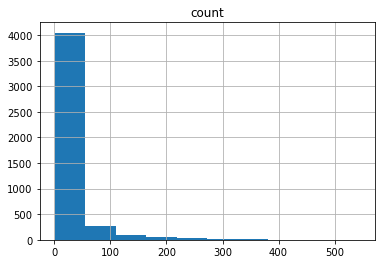

In [23]:
genre_sum.hist()

array([[<AxesSubplot:title={'center':'count'}>]], dtype=object)

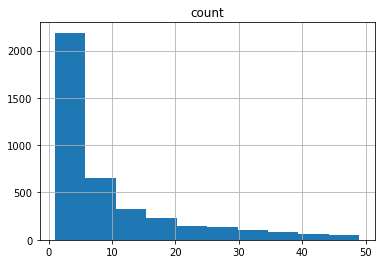

In [24]:
genre_sum[genre_sum["count"]<50].hist()

In [25]:
trivial = list(genre_sum.loc[genre_sum["count"]<20].index)

In [26]:
non_trivial_genres = genres.drop(trivial, axis=1, inplace=False)
non_trivial_genres

,"""canzone d'autore""",'abstract hip hop','acid house','acoustic blues','acoustic cover','acoustic pop','adoracao','adult standards','aesthetic rap','african rock',...,'volksmusik','wave','west coast rap','west coast trap','wonky','world worship','world','worship','yacht rock','zouk riddim'
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9769,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5031,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11147,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7185,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [27]:
non_trivial_genres["tot_genres"] = non_trivial_genres.sum(axis=1)

In [28]:
non_trivial_genres.sum(axis=0)

"canzone d'autore"       22
'abstract hip hop'       25
'acid house'             27
'acoustic blues'         21
'acoustic cover'         23
                      ...  
'world'                  59
'worship'                49
'yacht rock'             30
'zouk riddim'            54
tot_genres            83330
Length: 1167, dtype: int64

In [29]:
non_trivial_genres[["tot_genres"]]

,tot_genres
0,1
1,1
2,0
3,4
4,2
...,...
9769,1
5031,1
11147,3
7185,3


In [30]:
gens = list(non_trivial_genres.columns)
genre_dict = {}
for i in range(len(gens)-1):
    genre_dict[gens[i]] = i

In [31]:
node_df = pd.concat([node_df, non_trivial_genres], axis = 1)
node_df

,spotify_id,name,followers,popularity,genres,chart_hits,n_genres,popularity_norm,log_followers,"""canzone d'autore""",...,'wave','west coast rap','west coast trap','wonky','world worship','world','worship','yacht rock','zouk riddim',tot_genres
0,48WvrUGoijadXXCsGocwM4,Byklubben,1738.0,24,"'nordic house', 'russelater'",['no (3)'],2,0.24,7.460490,0,...,0,0,0,0,0,0,0,0,0,1
1,4lDiJcOJ2GLCK6p9q5BgfK,Kontra K,1999676.0,72,"'christlicher rap', 'german hip hop'","['at (44)', 'de (111)', 'lu (22)', 'ch (31)', ...",2,0.72,14.508496,0,...,0,0,0,0,0,0,0,0,0,1
2,652XIvIBNGg3C0KIGEJWit,Maxim,34596.0,36,,['de (1)'],0,0.36,10.451493,0,...,0,0,0,0,0,0,0,0,0,0
3,3dXC1YPbnQPsfHPVkm1ipj,Christopher Martin,249233.0,52,"'dancehall', 'lovers rock', 'modern reggae', '...","['at (1)', 'de (1)']",4,0.52,12.426143,0,...,0,0,0,0,0,0,0,0,0,4
4,74terC9ol9zMo8rfzhSOiG,Jakob Hellman,21193.0,39,"'classic swedish pop', 'norrbotten indie', 'sw...",['se (6)'],3,0.39,9.961426,0,...,0,0,0,0,0,0,0,0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9769,7JH3Oqfoa7PwVSbxi0p69L,Akim And The Majistret,66097.0,34,'malaysian pop',['my (5)'],1,0.34,11.098879,0,...,0,0,0,0,0,0,0,0,0,1
5031,5RqcTk3xp9dW1BLsdQ0NE9,Aerozen,33617.0,49,'romanian trap',['ro (10)'],1,0.49,10.422787,0,...,0,0,0,0,0,0,0,0,0,1
11147,2DWVv9ET0trhdmdFYROQaJ,A/DA 阿達,1989.0,29,"'chinese hip hop', 'chinese r&b', 'taiwan pop'",['tw (2)'],3,0.29,7.595387,0,...,0,0,0,0,0,0,0,0,0,3
7185,6noxsCszBEEK04kCehugOp,A-Mei Chang,680051.0,58,"'c-pop', 'mandopop', 'taiwan pop'","['my (2)', 'sg (1)', 'tw (40)']",3,0.58,13.429923,0,...,0,0,0,0,0,0,0,0,0,3


In [32]:
node_df = node_df.loc[node_df["tot_genres"]>0]
node_df

,spotify_id,name,followers,popularity,genres,chart_hits,n_genres,popularity_norm,log_followers,"""canzone d'autore""",...,'wave','west coast rap','west coast trap','wonky','world worship','world','worship','yacht rock','zouk riddim',tot_genres
0,48WvrUGoijadXXCsGocwM4,Byklubben,1738.0,24,"'nordic house', 'russelater'",['no (3)'],2,0.24,7.460490,0,...,0,0,0,0,0,0,0,0,0,1
1,4lDiJcOJ2GLCK6p9q5BgfK,Kontra K,1999676.0,72,"'christlicher rap', 'german hip hop'","['at (44)', 'de (111)', 'lu (22)', 'ch (31)', ...",2,0.72,14.508496,0,...,0,0,0,0,0,0,0,0,0,1
3,3dXC1YPbnQPsfHPVkm1ipj,Christopher Martin,249233.0,52,"'dancehall', 'lovers rock', 'modern reggae', '...","['at (1)', 'de (1)']",4,0.52,12.426143,0,...,0,0,0,0,0,0,0,0,0,4
4,74terC9ol9zMo8rfzhSOiG,Jakob Hellman,21193.0,39,"'classic swedish pop', 'norrbotten indie', 'sw...",['se (6)'],3,0.39,9.961426,0,...,0,0,0,0,0,0,0,0,0,2
6,71BhXa24Zf5zcikUb00l2N,Juice,11312.0,37,"'swedish drill', 'swedish hip hop', 'swedish t...",['se (4)'],4,0.37,9.333619,0,...,0,0,0,0,0,0,0,0,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9769,7JH3Oqfoa7PwVSbxi0p69L,Akim And The Majistret,66097.0,34,'malaysian pop',['my (5)'],1,0.34,11.098879,0,...,0,0,0,0,0,0,0,0,0,1
5031,5RqcTk3xp9dW1BLsdQ0NE9,Aerozen,33617.0,49,'romanian trap',['ro (10)'],1,0.49,10.422787,0,...,0,0,0,0,0,0,0,0,0,1
11147,2DWVv9ET0trhdmdFYROQaJ,A/DA 阿達,1989.0,29,"'chinese hip hop', 'chinese r&b', 'taiwan pop'",['tw (2)'],3,0.29,7.595387,0,...,0,0,0,0,0,0,0,0,0,3
7185,6noxsCszBEEK04kCehugOp,A-Mei Chang,680051.0,58,"'c-pop', 'mandopop', 'taiwan pop'","['my (2)', 'sg (1)', 'tw (40)']",3,0.58,13.429923,0,...,0,0,0,0,0,0,0,0,0,3


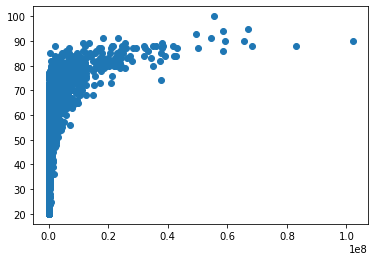

In [33]:
# Correlation between followers and popularity
node_df["followers"].corr(node_df["popularity"])
plt.scatter(node_df["followers"], node_df["popularity"])

Logarithmic relationship between followers and popularity

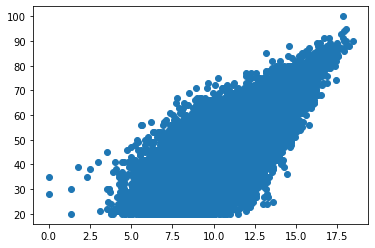

In [34]:
nonzero_nodes = node_df.loc[node_df["followers"]>0]
plt.scatter(np.log(nonzero_nodes["followers"]), nonzero_nodes["popularity"])
plt.show()

In [35]:
node_df["popularity"].corr(node_df["log_followers"])

0.7726779837986857

In [36]:
node_df.reset_index(inplace=True)
node_df.reset_index(inplace=True)

In [37]:
node_df

,level_0,index,spotify_id,name,followers,popularity,genres,chart_hits,n_genres,popularity_norm,...,'wave','west coast rap','west coast trap','wonky','world worship','world','worship','yacht rock','zouk riddim',tot_genres
0,0,0,48WvrUGoijadXXCsGocwM4,Byklubben,1738.0,24,"'nordic house', 'russelater'",['no (3)'],2,0.24,...,0,0,0,0,0,0,0,0,0,1
1,1,1,4lDiJcOJ2GLCK6p9q5BgfK,Kontra K,1999676.0,72,"'christlicher rap', 'german hip hop'","['at (44)', 'de (111)', 'lu (22)', 'ch (31)', ...",2,0.72,...,0,0,0,0,0,0,0,0,0,1
2,2,3,3dXC1YPbnQPsfHPVkm1ipj,Christopher Martin,249233.0,52,"'dancehall', 'lovers rock', 'modern reggae', '...","['at (1)', 'de (1)']",4,0.52,...,0,0,0,0,0,0,0,0,0,4
3,3,4,74terC9ol9zMo8rfzhSOiG,Jakob Hellman,21193.0,39,"'classic swedish pop', 'norrbotten indie', 'sw...",['se (6)'],3,0.39,...,0,0,0,0,0,0,0,0,0,2
4,4,6,71BhXa24Zf5zcikUb00l2N,Juice,11312.0,37,"'swedish drill', 'swedish hip hop', 'swedish t...",['se (4)'],4,0.37,...,0,0,0,0,0,0,0,0,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40483,40483,9769,7JH3Oqfoa7PwVSbxi0p69L,Akim And The Majistret,66097.0,34,'malaysian pop',['my (5)'],1,0.34,...,0,0,0,0,0,0,0,0,0,1
40484,40484,5031,5RqcTk3xp9dW1BLsdQ0NE9,Aerozen,33617.0,49,'romanian trap',['ro (10)'],1,0.49,...,0,0,0,0,0,0,0,0,0,1
40485,40485,11147,2DWVv9ET0trhdmdFYROQaJ,A/DA 阿達,1989.0,29,"'chinese hip hop', 'chinese r&b', 'taiwan pop'",['tw (2)'],3,0.29,...,0,0,0,0,0,0,0,0,0,3
40486,40486,7185,6noxsCszBEEK04kCehugOp,A-Mei Chang,680051.0,58,"'c-pop', 'mandopop', 'taiwan pop'","['my (2)', 'sg (1)', 'tw (40)']",3,0.58,...,0,0,0,0,0,0,0,0,0,3


In [38]:
node_df["followers_norm"]=MinMaxScaler().fit_transform(node_df[["log_followers"]])

C:\Users\wchen\AppData\Local\Temp/ipykernel_14628/4147512650.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  node_df["followers_norm"]=MinMaxScaler().fit_transform(node_df[["log_followers"]])


<AxesSubplot:>

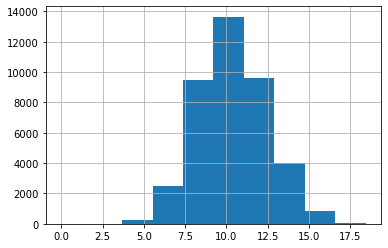

In [39]:
node_df["log_followers"].hist()

In [40]:
features = list(non_trivial_genres.columns)[:-1]
features.append("popularity_norm")
features.append("followers_norm")

In [41]:
#node_ids = node_df["spotify_id"]
node_attrs = torch.tensor(node_df[features].values, dtype=torch.float)

In [42]:
# FUll dataset: 156222
len(node_attrs)

40488

In [43]:
node_attrs.shape

torch.Size([40488, 1168])

## Process Edges

In [44]:
# Edge list of collaborations between artists 
edges_df

,id_0,id_1
0,76M2Ekj8bG8W7X2nbx2CpF,7sfl4Xt5KmfyDs2T3SVSMK
1,0hk4xVujcyOr6USD95wcWb,7Do8se3ZoaVqUt3woqqSrD
2,38jpuy3yt3QIxQ8Fn1HTeJ,4csQIMQm6vI2A2SCVDuM2z
3,6PvcxssrQ0QaJVaBWHD07l,6UCQYrcJ6wab6gnQ89OJFh
4,2R1QrQqWuw3IjoP5dXRFjt,4mk1ScvOUkuQzzCZpT6bc0
...,...,...
300381,0PK0Dx3s9et0Uf4XbdFpiW,6SmpksRq3jxeDZ7roKDb6F
300382,5hqRsNHDZH1jHzI9LgxFRZ,7KYseTkErcYMRvcIqacxUq
300383,0wjb0t7aYMuIwyuXnPOilh,2p1fiYHYiXz9qi0JJyxBzN
300384,3ciRvbBIVz9fBoPbtSYq4x,5einkgXXrjhfYCyac1FANB


In [45]:
artist_key = node_df[["level_0", "spotify_id"]]
artist_key.columns = ["artist1", "id_0"]
artist_key

,artist1,id_0
0,0,48WvrUGoijadXXCsGocwM4
1,1,4lDiJcOJ2GLCK6p9q5BgfK
2,2,3dXC1YPbnQPsfHPVkm1ipj
3,3,74terC9ol9zMo8rfzhSOiG
4,4,71BhXa24Zf5zcikUb00l2N
...,...,...
40483,40483,7JH3Oqfoa7PwVSbxi0p69L
40484,40484,5RqcTk3xp9dW1BLsdQ0NE9
40485,40485,2DWVv9ET0trhdmdFYROQaJ
40486,40486,6noxsCszBEEK04kCehugOp


In [46]:
edges_df_merge = edges_df.merge(artist_key, how = 'left', on='id_0', indicator=True)
#artist_key.columns = []
#edges_df_merge = edges_df_merge.merge()

In [47]:
# Remove any connections with unknown artist IDs
# 812 connections removed 
edges_df_merge = edges_df_merge[edges_df_merge['_merge']=='both']
edges_df_merge.drop('_merge', axis=1, inplace=True)
#edges_df.shape[0]-edges_df_merge.shape[0]

In [48]:
edges_df_merge

,id_0,id_1,artist1
0,76M2Ekj8bG8W7X2nbx2CpF,7sfl4Xt5KmfyDs2T3SVSMK,19893.0
1,0hk4xVujcyOr6USD95wcWb,7Do8se3ZoaVqUt3woqqSrD,6294.0
2,38jpuy3yt3QIxQ8Fn1HTeJ,4csQIMQm6vI2A2SCVDuM2z,37476.0
4,2R1QrQqWuw3IjoP5dXRFjt,4mk1ScvOUkuQzzCZpT6bc0,7409.0
5,0k70gnDBLPirCltbTzoxuM,5FK3qokBQYxr7ZLkr8GVFn,5983.0
...,...,...,...
300380,39yVoqm6sYFvvqF1RciUVf,5RwfJb8wxN1fuodcPORVxP,251.0
300381,0PK0Dx3s9et0Uf4XbdFpiW,6SmpksRq3jxeDZ7roKDb6F,10035.0
300382,5hqRsNHDZH1jHzI9LgxFRZ,7KYseTkErcYMRvcIqacxUq,6730.0
300384,3ciRvbBIVz9fBoPbtSYq4x,5einkgXXrjhfYCyac1FANB,6642.0


In [49]:
artist_key.columns = ["artist2", "id_1"]
edges_df_merge = edges_df_merge.merge(artist_key, how='left', on = 'id_1', indicator=True)

In [50]:
edges_df_merge = edges_df_merge[edges_df_merge['_merge']=='both']

In [51]:
edges_df_merge

,id_0,id_1,artist1,artist2,_merge
0,76M2Ekj8bG8W7X2nbx2CpF,7sfl4Xt5KmfyDs2T3SVSMK,19893.0,1388.0,both
1,0hk4xVujcyOr6USD95wcWb,7Do8se3ZoaVqUt3woqqSrD,6294.0,13802.0,both
2,38jpuy3yt3QIxQ8Fn1HTeJ,4csQIMQm6vI2A2SCVDuM2z,37476.0,4361.0,both
4,0k70gnDBLPirCltbTzoxuM,5FK3qokBQYxr7ZLkr8GVFn,5983.0,1708.0,both
5,1bAftSH8umNcGZ0uyV7LMg,1vqR17Iv8VFdzure1TAXEq,9820.0,13825.0,both
...,...,...,...,...,...
210530,0wr85NuJuAYZsRzP1lJgiV,3PtCud9dIdOv4exrzdZZ1C,9751.0,8936.0,both
210531,39yVoqm6sYFvvqF1RciUVf,5RwfJb8wxN1fuodcPORVxP,251.0,23502.0,both
210532,0PK0Dx3s9et0Uf4XbdFpiW,6SmpksRq3jxeDZ7roKDb6F,10035.0,34032.0,both
210534,3ciRvbBIVz9fBoPbtSYq4x,5einkgXXrjhfYCyac1FANB,6642.0,16575.0,both


In [52]:
edges_df_merge["artist1"].describe()

count    138583.000000
mean      12480.965248
std       10393.481124
min           1.000000
25%        4928.000000
50%        9592.000000
75%       15990.000000
max       40486.000000
Name: artist1, dtype: float64

In [53]:
edges_df_merge.drop(["id_0", "id_1", '_merge'], axis=1, inplace=True)

In [54]:
edges_df_merge

,artist1,artist2
0,19893.0,1388.0
1,6294.0,13802.0
2,37476.0,4361.0
4,5983.0,1708.0
5,9820.0,13825.0
...,...,...
210530,9751.0,8936.0
210531,251.0,23502.0
210532,10035.0,34032.0
210534,6642.0,16575.0


In [55]:
edges_df2 = edges_df_merge.copy()
edges_df2.columns = ["artist2", "artist1"]
edges_df2

,artist2,artist1
0,19893.0,1388.0
1,6294.0,13802.0
2,37476.0,4361.0
4,5983.0,1708.0
5,9820.0,13825.0
...,...,...
210530,9751.0,8936.0
210531,251.0,23502.0
210532,10035.0,34032.0
210534,6642.0,16575.0


In [56]:
edges_df_directed = pd.concat([edges_df_merge, edges_df2])
edges_df_directed

,artist1,artist2
0,19893.0,1388.0
1,6294.0,13802.0
2,37476.0,4361.0
4,5983.0,1708.0
5,9820.0,13825.0
...,...,...
210530,8936.0,9751.0
210531,23502.0,251.0
210532,34032.0,10035.0
210534,16575.0,6642.0


In [57]:
edges_df_directed[["artist1"]].min()

artist1    1.0
dtype: float64

In [58]:
edges = torch.tensor(edges_df_directed.values, dtype=torch.long)
edges

tensor([[19893,  1388],
        [ 6294, 13802],
        [37476,  4361],
        ...,
        [34032, 10035],
        [16575,  6642],
        [15250,  8747]])

## Load Data into Graph

In [176]:
# Create the graph object 
graph = Data(x=node_attrs, edge_index=edges.t().contiguous())

In [177]:
graph

Data(x=[40488, 1168], edge_index=[2, 277166])

In [61]:
graph.edge_index

tensor([[19893,  6294, 37476,  ..., 34032, 16575, 15250],
        [ 1388, 13802,  4361,  ..., 10035,  6642,  8747]])

In [62]:
graph.validate(raise_on_error=True)

True

In [63]:
graph.num_nodes
graph.num_edges
graph.num_node_features
graph.has_isolated_nodes()
graph.has_self_loops()
graph.is_directed()

False

In [64]:
G = to_networkx(graph, to_undirected=True) # Convert to networkx graph

In [63]:
def visualize_graph(G, color):
    plt.figure(figsize=(20,20))
    plt.xticks([])
    plt.yticks([])
    nx.draw_networkx(G, pos=nx.spring_layout(G, seed=42), with_labels=False, node_color=color) #, cmap="Set2"
    plt.show()

In [64]:
genre_dict

{'"canzone d\'autore"': 0,
 "'abstract hip hop'": 1,
 "'acid house'": 2,
 "'acoustic blues'": 3,
 "'acoustic cover'": 4,
 "'acoustic pop'": 5,
 "'adoracao'": 6,
 "'adult standards'": 7,
 "'aesthetic rap'": 8,
 "'african rock'": 9,
 "'afrikaans'": 10,
 "'afro dancehall'": 11,
 "'afro house'": 12,
 "'afro r&b'": 13,
 "'afro soul'": 14,
 "'afrofuturism'": 15,
 "'afrofuturismo brasileiro'": 16,
 "'afropop'": 17,
 "'afroswing'": 18,
 "'alabama rap'": 19,
 "'albanian hip hop'": 20,
 "'albanian pop'": 21,
 "'album rock'": 22,
 "'alt z'": 23,
 "'alte'": 24,
 "'alternative country'": 25,
 "'alternative dance'": 26,
 "'alternative hip hop'": 27,
 "'alternative metal'": 28,
 "'alternative r&b'": 29,
 "'alternative rock'": 30,
 "'amapiano'": 31,
 "'ambient'": 32,
 "'american orchestra'": 33,
 "'anadolu rock'": 34,
 "'anime rock'": 35,
 "'anime score'": 36,
 "'anime'": 37,
 "'antilliaanse rap'": 38,
 "'arab alternative'": 39,
 "'arab pop'": 40,
 "'arabesk'": 41,
 "'arabic hip hop'": 42,
 "'argentin

In [ ]:
# Visualize the largest connected component of the network 
# Not recommended on this large network, takes forever, need to do on a smaller subgraph
Gcc = sorted(nx.connected_components(G), key=len, reverse=True)
G0 = G.subgraph(Gcc[0])
c_nodes = []
for i in Gcc[0]:
    c_nodes.append(graph.x[i,696].numpy())
visualize_graph(G0, color = c_nodes)

## Centrality Analysis

In [63]:
deg = nx.degree_centrality(G)
eigen = nx.eigenvector_centrality(G)
close = nx.closeness_centrality(G)
between = nx.betweenness_centrality(G)

In [64]:
deg

{0: 0.05172413793103448,
 1: 0.059113300492610835,
 2: 0.07142857142857142,
 3: 0.09359605911330049,
 4: 0.10344827586206896,
 5: 0.05172413793103448,
 6: 0.017241379310344827,
 7: 0.059113300492610835,
 8: 0.0,
 9: 0.1625615763546798,
 10: 0.09605911330049262,
 11: 0.03201970443349754,
 12: 0.0049261083743842365,
 13: 0.014778325123152709,
 14: 0.059113300492610835,
 15: 0.04433497536945813,
 16: 0.0,
 17: 0.0049261083743842365,
 18: 0.007389162561576354,
 19: 0.009852216748768473,
 20: 0.0,
 21: 0.04187192118226601,
 22: 0.10344827586206896,
 23: 0.027093596059113302,
 24: 0.059113300492610835,
 25: 0.0,
 26: 0.009852216748768473,
 27: 0.06157635467980296,
 28: 0.022167487684729065,
 29: 0.0049261083743842365,
 30: 0.0665024630541872,
 31: 0.05665024630541872,
 32: 0.07142857142857142,
 33: 0.0024630541871921183,
 34: 0.08620689655172414,
 35: 0.04187192118226601,
 36: 0.014778325123152709,
 37: 0.0024630541871921183,
 38: 0.014778325123152709,
 39: 0.022167487684729065,
 40: 0.08866

In [65]:
deg_df = pd.DataFrame.from_dict(deg, orient="index", columns = ["deg"])
eigen_df = pd.DataFrame.from_dict(eigen, orient="index", columns = ["eig"])
close_df = pd.DataFrame.from_dict(close, orient="index", columns = ["close"])
bet_df = pd.DataFrame.from_dict(between, orient="index", columns = ["bet"])
centrality_df = pd.concat([deg_df, eigen_df, close_df, bet_df], axis=1)

In [66]:
node_df = pd.concat([node_df, centrality_df], axis=1)
node_df

,level_0,index,spotify_id,name,followers,popularity,genres,chart_hits,n_genres,popularity_norm,...,'uk dance','uk pop','urban contemporary','west coast rap',tot_genres,followers_norm,deg,eig,close,bet
0,0,23,6M2wZ9GZgrQXHCFfjv46we,Dua Lipa,36163788.0,88,"'dance pop', 'pop', 'uk pop'","['us (17)', 'gb (25)', 'ar (18)', 'au (20)', '...",3,0.88,...,0,1,0,0,3,0.873264,0.051724,3.226665e-02,0.383758,0.003608
1,1,137,23fqKkggKUBHNkbKtXEls4,Kygo,8134874.0,80,"'edm', 'pop', 'pop dance', 'tropical house'","['us (28)', 'gb (24)', 'ar (9)', 'au (24)', 'a...",4,0.80,...,0,0,0,0,4,0.691188,0.059113,2.212861e-02,0.368876,0.009298
2,2,230,360IAlyVv4PCEVjgyMZrxK,Miguel,4195623.0,77,"'dance pop', 'pop', 'r&b', 'urban contemporary'","['us (10)', 'gb (1)', 'ar (1)', 'au (4)', 'be ...",4,0.77,...,0,0,1,0,4,0.610381,0.071429,5.798322e-02,0.376395,0.002604
3,3,242,4kYSro6naA4h99UJvo89HB,Cardi B,20361435.0,80,"'dance pop', 'pop', 'rap'","['us (19)', 'gb (17)', 'ar (2)', 'au (16)', 'a...",3,0.80,...,0,0,0,0,3,0.803160,0.093596,7.414282e-02,0.395357,0.007469
4,4,273,5f7VJjfbwm532GiveGC0ZK,Lil Baby,11530234.0,89,"'atl hip hop', 'atl trap', 'rap', 'trap'","['us (62)', 'gb (16)', 'au (6)', 'at (3)', 'be...",4,0.89,...,0,0,0,0,3,0.733758,0.103448,9.412565e-02,0.383758,0.004923
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
402,402,19550,1wZtkThiXbVNtj6hee6dz9,Wisin & Yandel,5655168.0,79,"'electro latino', 'latin hip hop', 'reggaeton'...","['ar (5)', 'bo (7)', 'cl (13)', 'co (8)', 'cr ...",4,0.79,...,0,0,0,0,3,0.646814,0.081281,6.448896e-02,0.365441,0.001756
403,403,62564,2fMqTqiTxUDlmcOEPaQSsx,Amitabh Bhattacharya,28232.0,75,'modern bollywood',NaN,1,0.75,...,0,0,0,0,1,0.000000,0.004926,8.168778e-05,0.225028,0.000000
404,404,63462,1Oa0bMld0A3u5OTYfMzp5h,Nate Dogg,1300744.0,75,"'g funk', 'gangster rap', 'hip hop', 'pop rap'...",NaN,6,0.75,...,0,0,0,1,5,0.467455,0.017241,1.038575e-02,0.304180,0.000019
405,405,68244,2ae6PxICSOZHvjqiCcgon8,S. P. Balasubrahmanyam,5086667.0,75,'filmi',NaN,1,0.75,...,0,0,0,0,1,0.633884,0.009852,1.034250e-05,0.191061,0.000006


In [67]:
node_df["bet"].corr(node_df["popularity"])

0.28586250798499724

In [199]:
G.edges

EdgeView([(0, 11), (0, 318), (0, 202), (0, 267), (0, 270), (0, 143), (0, 119), (0, 165), (0, 107), (0, 122), (0, 365), (0, 325), (0, 382), (0, 156), (0, 172), (0, 181), (0, 303), (0, 30), (0, 213), (0, 288), (0, 2), (1, 177), (1, 142), (1, 205), (1, 38), (1, 52), (1, 338), (1, 106), (1, 202), (1, 258), (1, 17), (1, 314), (1, 76), (1, 386), (1, 144), (1, 390), (1, 133), (1, 2), (1, 157), (1, 275), (1, 303), (1, 304), (1, 253), (1, 162), (1, 189), (2, 273), (2, 272), (2, 110), (2, 164), (2, 168), (2, 156), (2, 252), (2, 236), (2, 268), (2, 151), (2, 267), (2, 398), (2, 60), (2, 106), (2, 309), (2, 242), (2, 215), (2, 96), (2, 159), (2, 257), (2, 30), (2, 310), (2, 355), (2, 233), (2, 112), (2, 369), (2, 305), (3, 397), (3, 34), (3, 237), (3, 179), (3, 283), (3, 14), (3, 285), (3, 5), (3, 401), (3, 186), (3, 309), (3, 222), (3, 335), (3, 213), (3, 146), (3, 162), (3, 369), (3, 220), (3, 91), (3, 243), (3, 154), (3, 235), (3, 307), (3, 27), (3, 354), (3, 215), (3, 232), (3, 82), (3, 294), 

## Negative Sampling and Train-Test Split

In [65]:
# Perform negative sampling of edges 
neg_sample = negative_sampling(edge_index=graph.edge_index, #positive edges
                               num_nodes=graph.num_nodes, # number of nodes
                               num_neg_samples=graph.edge_index.size(1)) # number of neg_sample equal to number of pos_edges

In [66]:
# Combine positive and negative edges for a full sample 
full_sample = torch.cat((graph.edge_index, neg_sample), 1)

In [67]:
full_sample

tensor([[19893,  6294, 37476,  ..., 28294, 32653, 30528],
        [ 1388, 13802,  4361,  ...,  3057, 26611,   387]])

In [68]:
full_sample.shape

torch.Size([2, 554332])

In [218]:
# Create the labels for the full sample 
lbls = np.concatenate((np.ones(graph.edge_index.shape[1]), np.zeros(graph.edge_index.shape[1])))

In [70]:
# Create a training graph by randomly removing a portion of the existing edges (in this case 30%)
train_edges, supervision_edges = train_test_split(graph.edge_index.T.numpy(), test_size=0.3, random_state=42)
t_edges = torch.tensor(train_edges, dtype=torch.long)
train_graph = Data(x=node_attrs, edge_index=t_edges.t().contiguous()) # Pytorch Geometric graph
trainG = to_networkx(train_graph, to_undirected=True) # NetworkX graph for Jaccard and Adamic-Adar

In [72]:
train_graph

Data(x=[40488, 1168], edge_index=[2, 194016])

In [73]:
graph

Data(x=[40488, 1168], edge_index=[2, 277166])

In [77]:
train_graph.edge_index.shape[1]/graph.edge_index.shape[1] # Confirm 70% of edges remaining

0.6999992784107719

In [200]:
# Sample of edges in training graph and equal number of negative edges
train_sample = torch.cat((t_edges.t(), neg_sample[:,:train_edges.shape[0]]), 1)
train_sample

tensor([[24126, 32395,   396,  ...,   803, 11748, 12934],
        [ 5857,  6568, 16473,  ..., 15496, 33707, 24840]])

In [206]:
# Labels for the training sample
train_lbls = lbls = np.concatenate((np.ones(train_edges.shape[0]), np.zeros(train_edges.shape[0])))
train_lbls

array([1., 1., 1., ..., 0., 0., 0.])

In [202]:
# Test sample of removed/masked edges and equal number of negative edges
test_sample = torch.cat((torch.tensor(supervision_edges).t(), neg_sample[:,train_edges.shape[0]:]), 1)
test_sample

tensor([[11344,  4560,  9112,  ..., 28294, 32653, 30528],
        [ 8933,  4782, 12342,  ...,  3057, 26611,   387]])

In [203]:
test_sample.shape

torch.Size([2, 166300])

In [213]:
# Labels for the test sample
test_lbls = lbls = np.concatenate((np.ones(int(test_sample.shape[1]/2)), np.zeros(int(test_sample.shape[1]/2))))
test_lbls.shape

(166300,)

## Link Prediction Using Jaccard

In [ ]:
# Calculate Jaccard Measure for all edges in sample
jac = list(nx.jaccard_coefficient(trainG, full_sample.T.numpy()))
jac[0:10]

In [228]:
# Calculate Jaccard Measure for training edges
train_jac = list(nx.jaccard_coefficient(trainG, train_sample.T.numpy()))
train_jac[0:10]

[(24126, 5857, 0.0),
 (32395, 6568, 0.0),
 (396, 16473, 0.10810810810810811),
 (12517, 2383, 0.0),
 (9583, 2496, 0.017699115044247787),
 (8524, 9206, 0.1056338028169014),
 (5229, 2984, 0.0),
 (12270, 4679, 0.0),
 (15733, 13522, 0.038461538461538464),
 (16152, 9674, 0.0)]

In [229]:
# Calculate Jaccard Measure for supervision (test) edges
test_jac = list(nx.jaccard_coefficient(trainG, test_sample.T.numpy()))
test_jac[0:10]

[(11344, 8933, 0.07692307692307693),
 (4560, 4782, 0.08461538461538462),
 (9112, 12342, 0.12244897959183673),
 (1049, 5383, 0.030303030303030304),
 (15066, 10289, 0.0),
 (11136, 37006, 0.0),
 (9820, 16190, 0.06153846153846154),
 (25874, 6936, 0.0),
 (20659, 12036, 0.025),
 (11814, 5593, 0.05128205128205128)]

In [ ]:
df = pd.DataFrame(jac, columns =['Artist1', 'Artist2', 'Jaccard'])
df

In [230]:
train_df = pd.DataFrame(train_jac, columns =['Artist1', 'Artist2', 'Jaccard'])
train_df

,Artist1,Artist2,Jaccard
0,24126,5857,0.000000
1,32395,6568,0.000000
2,396,16473,0.108108
3,12517,2383,0.000000
4,9583,2496,0.017699
...,...,...,...
388027,2959,8657,0.000000
388028,37270,28501,0.000000
388029,803,15496,0.000000
388030,11748,33707,0.000000


In [231]:
test_df = pd.DataFrame(test_jac, columns =['Artist1', 'Artist2', 'Jaccard'])
test_df

,Artist1,Artist2,Jaccard
0,11344,8933,0.076923
1,4560,4782,0.084615
2,9112,12342,0.122449
3,1049,5383,0.030303
4,15066,10289,0.000000
...,...,...,...
166295,12646,31398,0.000000
166296,3116,12939,0.000000
166297,28294,3057,0.000000
166298,32653,26611,0.000000


In [235]:
train_df["lbl"] = train_lbls
test_df["lbl"] = test_lbls

In [219]:
df["lbl"] = lbls

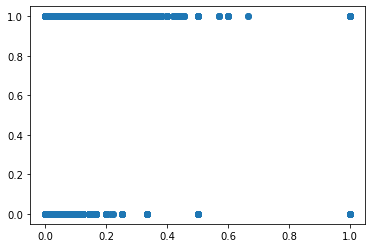

In [220]:
plt.scatter(df["Jaccard"], df["lbl"])

In [237]:
# Train classifier
jac_model = LogisticRegression(random_state=0).fit(train_df[["Jaccard"]], train_df["lbl"])
#jac_mode = RandomForestClassifier(random_state=10).fit(X_train, y_train)
#jac_mode = SVC(random_state=10).fit(X_train, y_train)

In [238]:
# Generate predictions for test set
preds = jac_model.predict(test_df[["Jaccard"]])
probs = jac_model.predict_proba(test_df[["Jaccard"]])

In [240]:
roc_auc_score(test_df["lbl"], preds)

0.7540408899579073

In [241]:
accuracy_score(test_df["lbl"], preds)

0.7540408899579074

In [242]:
f1_score(test_df["lbl"], preds)

0.6747353939866245

### Adamic Adar

In [87]:
adamic = list(nx.adamic_adar_index(trainG, full_sample.T.numpy()))
adamic[0:10]

[(19893, 1388, 0),
 (6294, 13802, 1.494326169655899),
 (37476, 4361, 0),
 (5983, 1708, 0),
 (9820, 13825, 2.2640027175380033),
 (7465, 8739, 0.23537745555238682),
 (6757, 39148, 0),
 (737, 22599, 0),
 (368, 10591, 0),
 (12621, 8062, 1.4426950408889634)]

In [243]:
# Calculate Jaccard Measure for training edges
train_adamic = list(nx.adamic_adar_index(trainG, train_sample.T.numpy()))
train_adamic[0:10]

[(24126, 5857, 0),
 (32395, 6568, 0),
 (396, 16473, 1.0735905112891775),
 (12517, 2383, 0),
 (9583, 2496, 0.4654506727820568),
 (8524, 9206, 4.3187320233844595),
 (5229, 2984, 0),
 (12270, 4679, 0),
 (15733, 13522, 0.602498638493973),
 (16152, 9674, 0)]

In [244]:
# Calculate Jaccard Measure for supervision (test) edges
test_adamic = list(nx.adamic_adar_index(trainG, test_sample.T.numpy()))
test_adamic[0:10]

[(11344, 8933, 1.2316189249543432),
 (4560, 4782, 2.52288584963215),
 (9112, 12342, 3.1143077843483447),
 (1049, 5383, 0.6773371821243382),
 (15066, 10289, 0),
 (11136, 37006, 0),
 (9820, 16190, 1.104407945886212),
 (25874, 6936, 0),
 (20659, 12036, 0.25433477814404226),
 (11814, 5593, 0.8173114179120299)]

In [88]:
adamic_df = pd.DataFrame(adamic, columns =['Artist1', 'Artist2', 'Adamic'])
adamic_df["lbl"] = lbls
adamic_df

,Artist1,Artist2,Adamic,lbl
0,19893,1388,0.000000,1.0
1,6294,13802,1.494326,1.0
2,37476,4361,0.000000,1.0
3,5983,1708,0.000000,1.0
4,9820,13825,2.264003,1.0
...,...,...,...,...
554327,12646,31398,0.000000,0.0
554328,3116,12939,0.000000,0.0
554329,28294,3057,0.000000,0.0
554330,32653,26611,0.000000,0.0


In [245]:
train_adamic_df = pd.DataFrame(train_adamic, columns =['Artist1', 'Artist2', 'Adamic'])
train_adamic_df["lbl"] = train_lbls
train_adamic_df

,Artist1,Artist2,Adamic,lbl
0,24126,5857,0.000000,1.0
1,32395,6568,0.000000,1.0
2,396,16473,1.073591,1.0
3,12517,2383,0.000000,1.0
4,9583,2496,0.465451,1.0
...,...,...,...,...
388027,2959,8657,0.000000,0.0
388028,37270,28501,0.000000,0.0
388029,803,15496,0.000000,0.0
388030,11748,33707,0.000000,0.0


In [246]:
test_adamic_df = pd.DataFrame(test_adamic, columns =['Artist1', 'Artist2', 'Adamic'])
test_adamic_df["lbl"] = test_lbls
test_adamic_df

,Artist1,Artist2,Adamic,lbl
0,11344,8933,1.231619,1.0
1,4560,4782,2.522886,1.0
2,9112,12342,3.114308,1.0
3,1049,5383,0.677337,1.0
4,15066,10289,0.000000,1.0
...,...,...,...,...
166295,12646,31398,0.000000,0.0
166296,3116,12939,0.000000,0.0
166297,28294,3057,0.000000,0.0
166298,32653,26611,0.000000,0.0


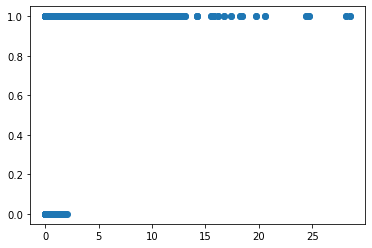

In [89]:
plt.scatter(adamic_df["Adamic"], adamic_df["lbl"])

In [247]:
# Train model
adamic_model = LogisticRegression(random_state=0).fit(train_adamic_df[["Adamic"]], train_adamic_df["lbl"])

In [248]:
# Generate predictions for test set
preds = adamic_model.predict(test_adamic_df[["Adamic"]])
probs = adamic_model.predict_proba(test_adamic_df[["Adamic"]])

In [249]:
accuracy_score(test_adamic_df[["lbl"]], preds)

0.7561815995189417

In [250]:
roc_auc_score(test_adamic_df[["lbl"]], preds)

0.7561815995189417

In [251]:
f1_score(test_adamic_df[["lbl"]], preds)

0.6784867539428926

## Link Prediction with GNN

From https://github.com/AntonioLonga/PytorchGeometricTutorial/blob/main/Tutorial12/Tutorial12%20GAE%20for%20link%20prediction.ipynb

In [211]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [164]:
# Note: Run GNN workflow last as it changes the original pytorch geoemetric graph object
data = train_test_split_edges(graph, val_ratio=0.1, test_ratio=0.2) # Employ 70-10-20 train, validation, test split
print(data)

C:\Users\wchen\.conda\envs\spotify\lib\site-packages\torch_geometric\deprecation.py:12: UserWarning: 'train_test_split_edges' is deprecated, use 'transforms.RandomLinkSplit' instead
  warnings.warn(out)


Data(x=[40488, 1168], val_pos_edge_index=[2, 13858], test_pos_edge_index=[2, 27716], train_pos_edge_index=[2, 194018], train_neg_adj_mask=[40488, 40488], val_neg_edge_index=[2, 13858], test_neg_edge_index=[2, 27716])


In [165]:
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = GCNConv(data.num_features, 128)
        self.conv2 = GCNConv(128, 64)

    def encode(self):
        x = self.conv1(data.x, data.train_pos_edge_index) # convolution 1
        x = x.relu()
        return self.conv2(x, data.train_pos_edge_index) # convolution 2

    def decode(self, z, pos_edge_index, neg_edge_index): # only pos and neg edges
        edge_index = torch.cat([pos_edge_index, neg_edge_index], dim=-1) # concatenate pos and neg edges
        logits = (z[edge_index[0]] * z[edge_index[1]]).sum(dim=-1)  # dot product 
        return logits

    def decode_all(self, z): 
        prob_adj = z @ z.t() # get adj NxN
        return (prob_adj > 0).nonzero(as_tuple=False).t() # get predicted edge_list 

In [166]:
model, data = Net().to(device), data.to(device)
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.01)

In [167]:
def get_link_labels(pos_edge_index, neg_edge_index):
    # returns a tensor:
    # [1,1,1,1,...,0,0,0,0,0,..] with the number of ones is equel to the lenght of pos_edge_index
    # and the number of zeros is equal to the length of neg_edge_index
    E = pos_edge_index.size(1) + neg_edge_index.size(1)
    link_labels = torch.zeros(E, dtype=torch.float, device=device)
    link_labels[:pos_edge_index.size(1)] = 1.
    return link_labels


def train():
    model.train()

    neg_edge_index = negative_sampling(
        edge_index=data.train_pos_edge_index, #positive edges
        num_nodes=data.num_nodes, # number of nodes
        num_neg_samples=data.train_pos_edge_index.size(1)) # number of neg_sample equal to number of pos_edges

    optimizer.zero_grad()
    
    z = model.encode() #encode
    link_logits = model.decode(z, data.train_pos_edge_index, neg_edge_index) # decode
    
    link_labels = get_link_labels(data.train_pos_edge_index, neg_edge_index)
    loss = F.binary_cross_entropy_with_logits(link_logits, link_labels) 
    loss.backward()
    optimizer.step()

    return loss

In [168]:
@torch.no_grad()
def test():
    model.eval()
    perfs = []
    for prefix in ["val", "test"]:
        pos_edge_index = data[f'{prefix}_pos_edge_index']
        neg_edge_index = data[f'{prefix}_neg_edge_index']

        z = model.encode() # encode train
        link_logits = model.decode(z, pos_edge_index, neg_edge_index) # decode test or val
        link_probs = link_logits.sigmoid() # apply sigmoid
        link_preds = []
        for p in link_probs: # Generate predictions based on the probability
            if p>=0.5:
                link_preds.append(1)
            else:
                link_preds.append(0)
        
        link_labels = get_link_labels(pos_edge_index, neg_edge_index) # get link
        
        perfs.append(roc_auc_score(link_labels.cpu(), link_probs.cpu())) #compute roc_auc score  
        perfs.append(accuracy_score(link_labels.cpu(), link_preds)) # compute accuracy
        perfs.append(f1_score(link_labels.cpu(), link_preds)) # compute f1 score
    return perfs

In [169]:
best_val_perf = test_perf = test_acc = test_f1 = 0
for epoch in range(1, 101):
    train_loss = train()
    val_perf, val_acc, val_f1, tmp_test_perf, tmp_test_acc, tmp_test_f1 = test()
    
    if val_perf > best_val_perf:
        best_val_perf = val_perf
        test_perf = tmp_test_perf
        test_acc = tmp_test_acc
        test_f1 = tmp_test_f1
    log = 'Epoch: {:03d}, Loss: {:.4f}, Val: {:.4f}, Test: {:.4f}, Test Acc: {:.4f}, Test F1: {:.4f}'
    if epoch <= 10 or epoch % 5 == 0:
        print(log.format(epoch, train_loss, best_val_perf, test_perf, test_acc, test_f1))

Epoch: 001, Loss: 0.6597, Val: 0.8779, Test: 0.8762, Test Acc: 0.5000, Test F1: 0.6667
Epoch: 002, Loss: 0.6768, Val: 0.8988, Test: 0.8970, Test Acc: 0.5001, Test F1: 0.6667
Epoch: 003, Loss: 0.6007, Val: 0.9218, Test: 0.9202, Test Acc: 0.5275, Test F1: 0.6787
Epoch: 004, Loss: 0.6083, Val: 0.9343, Test: 0.9319, Test Acc: 0.5693, Test F1: 0.6978
Epoch: 005, Loss: 0.5918, Val: 0.9343, Test: 0.9319, Test Acc: 0.5693, Test F1: 0.6978
Epoch: 006, Loss: 0.5578, Val: 0.9343, Test: 0.9319, Test Acc: 0.5693, Test F1: 0.6978
Epoch: 007, Loss: 0.5298, Val: 0.9343, Test: 0.9319, Test Acc: 0.5693, Test F1: 0.6978
Epoch: 008, Loss: 0.5145, Val: 0.9343, Test: 0.9319, Test Acc: 0.5693, Test F1: 0.6978
Epoch: 009, Loss: 0.4987, Val: 0.9343, Test: 0.9319, Test Acc: 0.5693, Test F1: 0.6978
Epoch: 010, Loss: 0.4851, Val: 0.9343, Test: 0.9319, Test Acc: 0.5693, Test F1: 0.6978
Epoch: 015, Loss: 0.4427, Val: 0.9538, Test: 0.9503, Test Acc: 0.7427, Test F1: 0.7912
Epoch: 020, Loss: 0.4305, Val: 0.9604, Test

## Link Prediction with Node2Vec

In [109]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [110]:
train_graph = train_graph.to(device)

From https://github.com/AntonioLonga/PytorchGeometricTutorial/blob/main/Tutorial12/Tutorial12%20Node2Vec%20for%20label%20prediction.ipynb

In [111]:
model = Node2Vec(train_graph.edge_index, embedding_dim=128, walk_length=20, context_size=10, walks_per_node=10,
                 num_negative_samples=1, p=1, q=1, num_nodes=train_graph.x.shape[0], sparse=True).to(device)
loader = model.loader(batch_size=128, shuffle=True, num_workers=4)
optimizer = torch.optim.SparseAdam(list(model.parameters()), lr=0.01)

In [112]:
def train():
    model.train()
    total_loss = 0
    for pos_rw, neg_rw in loader:
        optimizer.zero_grad()
        loss = model.loss(pos_rw.to(device), neg_rw.to(device))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

In [113]:
losses = []
for epoch in range(1, 101):
    loss = train()
    losses.append(loss)
    #acc = test()
    if epoch<=10 or epoch % 5 == 0:
        print(f'Epoch: {epoch:02d}, Loss: {loss:.4f}')

Epoch: 01, Loss: 5.3317
Epoch: 02, Loss: 2.1795
Epoch: 03, Loss: 1.2782
Epoch: 04, Loss: 0.9858
Epoch: 05, Loss: 0.8899
Epoch: 06, Loss: 0.8524
Epoch: 07, Loss: 0.8344
Epoch: 08, Loss: 0.8247
Epoch: 09, Loss: 0.8185
Epoch: 10, Loss: 0.8148
Epoch: 15, Loss: 0.8099
Epoch: 20, Loss: 0.8103
Epoch: 25, Loss: 0.8105
Epoch: 30, Loss: 0.8106


KeyboardInterrupt: 

In [114]:
z = model()

In [115]:
#emb_128 = z.detach().cpu().numpy()
emb_128 = z.detach().cpu().numpy()

In [116]:
from sklearn.decomposition import PCA
# fit and transform using PCA
pca = PCA(n_components=2)
emb2d = pca.fit_transform(emb_128)

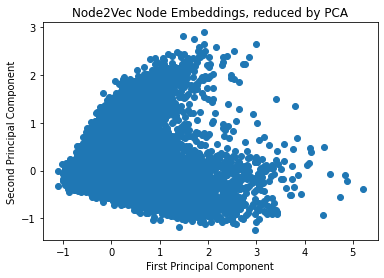

In [118]:
# Plot the node embeddings
plt.title("Node2Vec Node Embeddings, reduced by PCA")
plt.xlabel("First Principal Component")
plt.ylabel("Second Principal Component")
plt.scatter(emb2d[:,0],emb2d[:,1])
plt.show()

We can use different pooling methods to get the edge embeddings (from https://stellargraph.readthedocs.io/en/stable/demos/link-prediction/node2vec-link-prediction.html)

In [153]:
# Pool node embeddings to get edge embeddings
edge_embedding = []
for u,v in full_sample.T.numpy():
    #edge_embedding.append(np.mean([emb_128[u],emb_128[v]],0)) # Average pooling
    #edge_embedding.append(np.multiply(emb_128[u], emb_128[v])) # Hadamard product
    #edge_embedding.append(np.abs(emb_128[u] - emb_128[v])) # l1 operator
    edge_embedding.append((emb_128[u] - emb_128[v])**2) # l2 operator
edge_embedding = np.array(edge_embedding)

In [154]:
# fit and transform edge embeddings using PCA
pca_edge = PCA(n_components=2)
edge_emb2d = pca_edge.fit_transform(edge_embedding)

C:\Users\wchen\AppData\Local\Temp/ipykernel_14628/1924792436.py:6: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  plt.legend(lbls, labels = ["Edge Exists"])


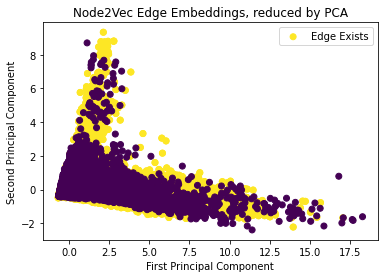

In [155]:
# Visualize the edge embeddings
plt.title("Node2Vec Edge Embeddings, reduced by PCA")
plt.xlabel("First Principal Component")
plt.ylabel("Second Principal Component")
plt.scatter(edge_emb2d[:,0],edge_emb2d[:,1], c=lbls)
plt.legend(lbls, labels = ["Edge Exists"])
plt.show()

In [275]:
# Generate training embeddings
train_edge_embedding = []
for u,v in train_sample.T.numpy():
    #train_edge_embedding.append(np.mean([emb_128[u],emb_128[v]],0)) # Average pooling
    #train_edge_embedding.append(np.multiply(emb_128[u], emb_128[v])) # Hadamard product
    #train_edge_embedding.append(np.abs(emb_128[u] - emb_128[v])) # l1 operator
    train_edge_embedding.append((emb_128[u] - emb_128[v])**2) # l2 operator
train_edge_embedding = np.array(train_edge_embedding)

In [276]:
# Generate test embeddings
test_edge_embedding = []
for u,v in test_sample.T.numpy():
    #test_edge_embedding.append(np.mean([emb_128[u],emb_128[v]],0)) # Average pooling
    #test_edge_embedding.append(np.multiply(emb_128[u], emb_128[v])) # Hadamard product
    #test_edge_embedding.append(np.abs(emb_128[u] - emb_128[v])) # l1 operator
    test_edge_embedding.append((emb_128[u] - emb_128[v])**2) # l2 operator
test_edge_embedding = np.array(test_edge_embedding)

In [277]:
# Train logistic classifier and generate predictions for test sample
n2v_classifier = LogisticRegression().fit(train_edge_embedding, train_lbls)#random_state=0
#n2v_classifier = RandomForestClassifier(random_state=10).fit(X_train, y_train)
#n2v_classifier = SVC(random_state=10).fit(X_train, y_train)
preds = n2v_classifier.predict(test_edge_embedding)
probs = n2v_classifier.predict_proba(test_edge_embedding)

In [278]:
roc_auc_score(test_lbls, preds)

0.7408418520745641

In [279]:
accuracy_score(test_lbls, preds)

0.740841852074564

In [280]:
f1_score(test_lbls, preds)

0.7351108160932256

In [262]:
print(classification_report(test_lbls, preds))

              precision    recall  f1-score   support

         0.0       0.92      0.99      0.95     83150
         1.0       0.99      0.91      0.95     83150

    accuracy                           0.95    166300
   macro avg       0.95      0.95      0.95    166300
weighted avg       0.95      0.95      0.95    166300

